In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath('../../../..')
tf.compat.v1.enable_eager_execution()
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.model import compute_backbone_shapes, load_image_gt
from mrcnn.model import build_rpn_targets
from ycbv_loader import YCBVDataset

In [2]:
class YCBVConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'ycb'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 1 + 21
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 320
    TRAIN_ROIS_PER_IMAGE = 100
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5
    
config = YCBVConfig()
# config.display()

In [3]:
data_dir = os.path.join(ROOT_DIR, '50_images')
dataset_train = YCBVDataset(data_dir, split='train')
dataset_train.load_ycbv()
dataset_train.prepare()

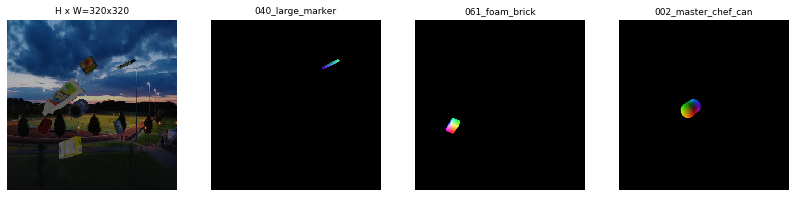

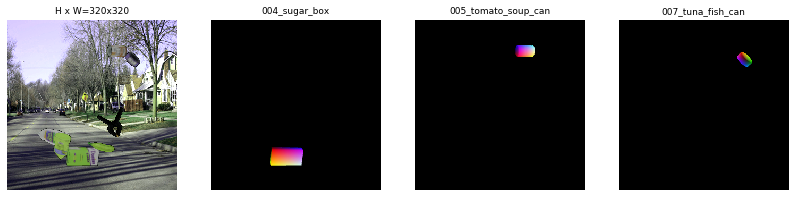

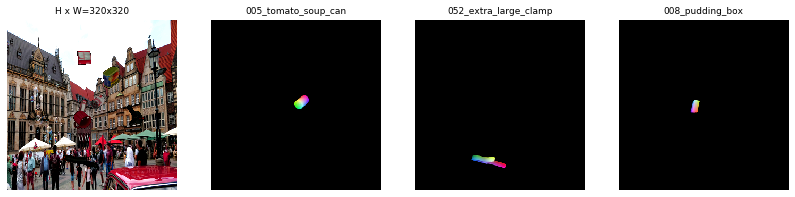

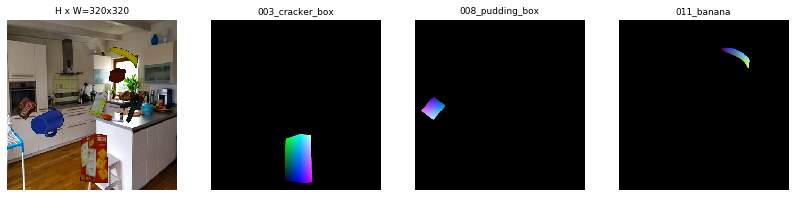

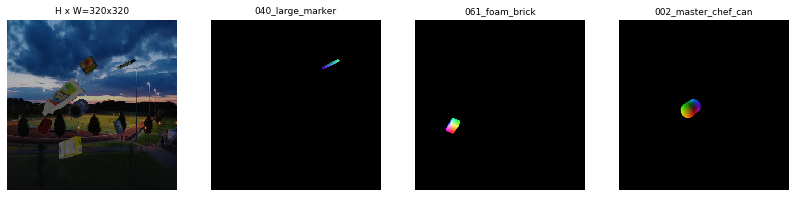

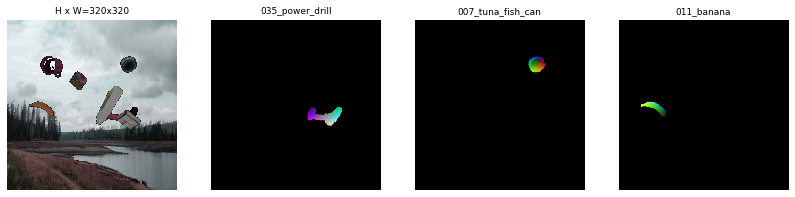

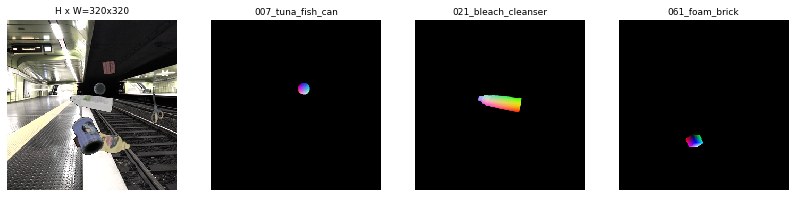

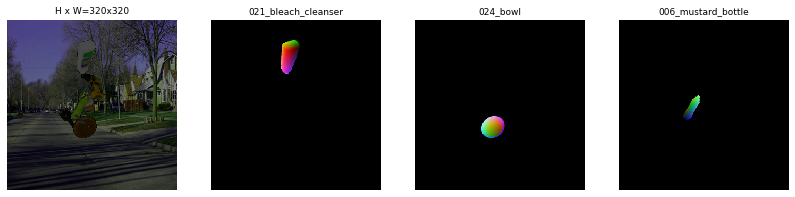

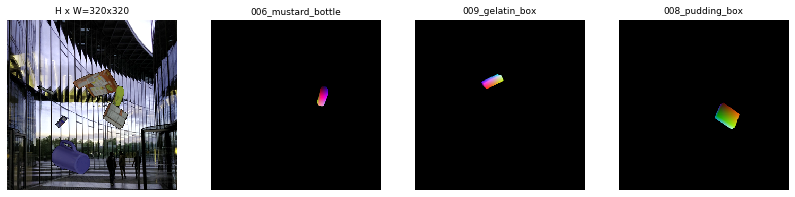

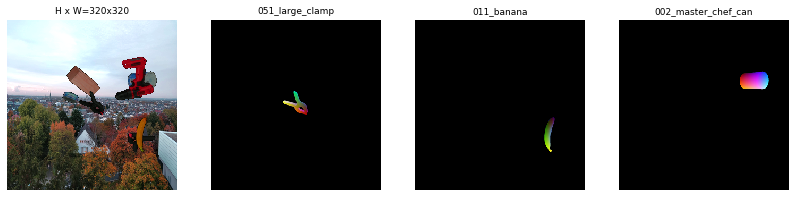

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    rgb_masks, class_ids = dataset_train.load_rgb_mask(image_id)
    visualize.display_rgb_top_masks(image, rgb_masks, class_ids, dataset_train.class_names, limit=3)

In [5]:
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours

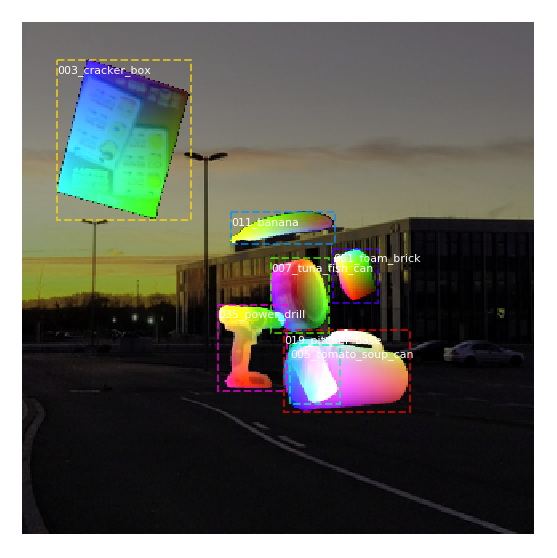

In [6]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image, _, class_id, bbox, r_masks, g_masks, b_masks = modellib.load_image_gt(dataset_train, config, image_id, use_mini_mask=False)
r_masks = (r_masks * 255).astype(np.uint8)
g_masks = (g_masks * 255).astype(np.uint8)
b_masks = (b_masks * 255).astype(np.uint8)
masks = []
for i in range(r_masks.shape[-1]):
    mask = np.stack([r_masks[:, :, i], g_masks[:, :, i], b_masks[:, :, i]], axis=2)
    masks.append(mask)
masks = np.stack(masks, axis=2)
rgb_mask = np.reshape(masks, (320, 320, 3*7))
visualize.display_rgb_instances(image, bbox, rgb_mask, class_id, dataset_train.class_names, figsize=(10, 10), show_bbox=True, show_mask=True)

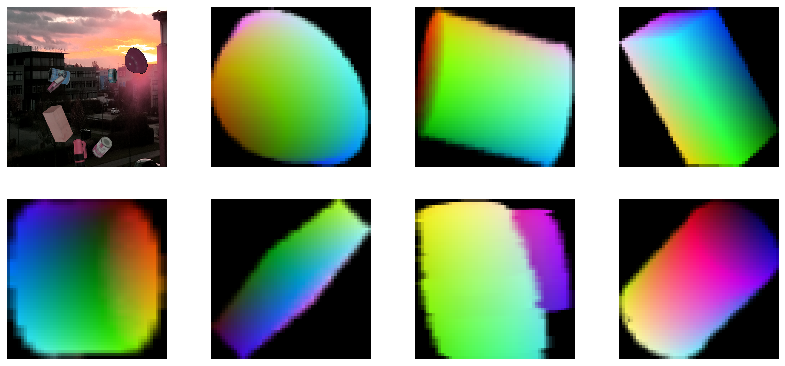

In [12]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image, _, class_id, bbox, r_masks, g_masks, b_masks = modellib.load_image_gt(dataset_train, config, image_id, use_mini_mask=True)
r_masks = (r_masks * 255).astype(np.uint8)
g_masks = (g_masks * 255).astype(np.uint8)
b_masks = (b_masks * 255).astype(np.uint8)
masks = []
for i in range(r_masks.shape[-1]):
    mask = np.stack([r_masks[:, :, i], g_masks[:, :, i], b_masks[:, :, i]], axis=2)
    masks.append(mask)
masks = np.stack(masks, axis=2)
rgb_mask = np.reshape(masks, (56, 56, 3*7))
# mini_mask = utils.minimize_rgb_mask(bbox, rgb_mask, config.MINI_MASK_SHAPE)
# plt.imshow(mini_mask[:, :, 0:3])
# plt.show()
# visualize.display_images([image]+[binary_mask[:, :, i] for i in range(0, binary_mask.shape[-1])])
visualize.display_images([image]+[rgb_mask[:, :, i:i+3] for i in range(0, rgb_mask.shape[-1], 3)])

In [7]:
gt_masks = tf.constant(mask.T[:, :, 0:3], dtype=tf.float32)
binary_masks, _ = dataset_train.load_mask(image_id)
pred_mask = binary_masks[:, :, 0]
print(np.unique(pred_mask))
# pred_masks = tf.constant(np.stack([pred_mask, pred_mask, pred_mask], axis=2), dtype=tf.float32)
# loss = K.binary_crossentropy(gt_masks, pred_masks, from_logits=True)
# print(K.mean(loss).numpy())

NameError: name 'mask' is not defined